## 1. 线性回归
线性假设是指目标（房屋价格）可以表示为特征（面积和房龄）的加权和：
$$
\hat{y} = w_1 x_1 + w_2 x_2 + b
$$
其中，$\hat{y}$ 是预测的房屋价格，$x_1$ 和 $x_2$ 是面积和房龄特征，$w_1$ 和 $w_2$ 是权重参数，$b$ 是偏置项。

我们有一堆真实的房屋数据（面积、房龄、真实价格）。我们用上面的公式去猜价格，肯定会和真实价格有差距。

损失函数，就是用来量化这个差距有多糟糕的尺子。最常用的尺子是平方误差：
$$
L(\hat{y}, y) = (\hat{y} - y)^2
$$
其中，$\hat{y}$ 是预测价格，$y$ 是真实价格。

我们的目标是找到一组最优的权重参数 $w_1, w_2, b$，使得所有训练样本的损失函数值的平均值最小。
$$
L(w_1, w_2, b) = \frac{1}{n} \sum_{i=1}^n L(\hat{y}_i, y_i)
$$
其中，$n$ 是训练样本数量，$\hat{y}_i$ 是第 $i$ 个样本的预测价格，$y_i$ 是第 $i$ 个样本的真实价格。

怎么调整 w 和 b 才能让损失最小呢？有两种主要思路：
- 解析解（closed-form solution）
  - 做不到，太麻烦了
- 梯度下降（gradient descent），常用的随机梯度下降（stochastic gradient descent）
  a. 随机初始化：先随便猜一组 w 和 b（比如都设成0或很小的随机数）。
  b. 看方向（算梯度）：计算一下当前参数下，损失函数在往哪个方向走会下降最快？这个方向就是“梯度”的反方向。
    - 若$dL/dw > 0$（梯度为正）：要让w变小（反方向），才能让$L(w)$下降；
    - 若$dL/dw < 0$（梯度为负）：要让w变大（反方向），才能让$L(w)$下降。
  c. 迈一小步（更新参数）：沿着能让损失下降的方向，把 w 和 b 调整一点点。这一步的大小叫做学习率。
  d. 重复：用新参数，再重复b和c步。每次都看方向，迈一小步。

以损失函数$L(w) = (w-5)²$（这是一个开口向上的抛物线，最小值在$w=5$）为例：
梯度$dL/dw = 2*(w-5)$
- 当$w=8$时，梯度 = 2*(8-5)=6（正数）→ 说明w变大，$L(w)$会更糟；所以要让w变小（往梯度反方向走），比如$w = 8 - lr*6$；
- 当$w=2$时，梯度 = 2*(2-5)=-6（负数）→ 说明w变大，$L(w)$会变好；所以要让w变大（还是往梯度反方向走），比如$w = 2 - lr*(-6) = 2 + lr*6$。

不管梯度是正还是负，更新参数的公式都是：新 w = 旧 w - 学习率 × 梯度—— 这里的减号，就是 “梯度的反方向” 的体现

当我们通过上面的方法，找到了一组让我们“损失最小”、也就是“预测最准”的 w 和 b 之后，这个模型就“学成了”。

这时，给你一套新的、没见过的房子（知道面积和房龄），你就能用我们学到的那个公式：
【预测价格】 = 【新面积】 × w₁ + 【新房龄】 × w₂ + b
来给它估个价了！这个过程就叫预测或推断。

### 1.1 矢量化加速
现在要计算 10,000 套房子的价格预测。你有两个选择：
- 选择A（笨办法）：拿个计算器，一套一套算，算 10,000 次。
- 选择B（聪明办法）：把所有房子的面积、房龄整理成表格，用一个巨大的公式（矩阵乘法）一次算出所有结果。
矢量化，就是选择B。它利用计算机的并行计算能力，一次性对整个向量（或矩阵）进行运算，而不是用循环逐个处理每个元素。
> 稍微了解一下就行，实际上 PyTorch 本身就支持矢量化相加

In [ ]:
import torch
import time

# 创建两个全1的向量
n = 10000
a = torch.ones(n)  # [1, 1, 1, ..., 1]（共10000个元素）
b = torch.ones(n)  # [1, 1, 1, ..., 1]

# 方法1: for循环（逐元素相加）
c = torch.zeros(n)  # 准备空结果向量
# 正确的计时方式：用time.time()记录开始/结束时间
start_time = time.time()
for i in range(n):          
    c[i] = a[i] + b[i]     
end_time = time.time()
loop_time = end_time - start_time
print(f'循环用时：{loop_time:.5f} 秒')

# 方法2: 矢量化（批量并行相加）
start_time = time.time()
d = a + b  # PyTorch底层并行处理所有元素的加法
end_time = time.time()
vectorized_time = end_time - start_time
print(f'矢量化用时：{vectorized_time:.5f} 秒')

# 验证两种方法结果一致（可选）
print(f'结果是否一致：{torch.allclose(c, d)}')  # 输出 True

循环用时：0.06515 秒
矢量化用时：0.00000 秒
结果是否一致：True


### 1.2 正态分布与平方损失
为什么偏偏选“平方误差”作为损失函数？而不是绝对值误差或其他？

我们承认，房价不可能完全由面积和房龄决定。还有无数其他因素：装修、学区、邻居、甚至卖家的心情...这些无法被模型捕捉的因素，我们统称为噪声。

一般而言，预设这个噪声为正态分布总不会错

1. 假设：真实值 y 等于预测值 ŷ 加上一个服从正态分布的噪声 ε。
y = ŷ + ε，其中 ε ~ N(0, σ²)
2. 翻译：根据正态分布的概率密度函数 (PDF),给定特征 x，观察到房价为 y 的概率是：
  
$$ P(y|x) = \frac{1}{\sqrt{2\pi}\sigma} \exp\left( -\frac{(y - \hat{y})^2}{2\sigma^2} \right) $$
> 当你的预测 ŷ 离真实值 y 越远，这个概率就越小
1. 最大似然估计(Max Likelihood Estimation, MLE)：我们想找到一组参数 w, b，使得整个数据集（包含 $n$ 个独立样本）出现的概率最大。这就需要将所有样本的概率相乘（联合概率）：

$$ L(w, b) = \prod_{i=1}^{n} P(y^{(i)} | x^{(i)}) $$

$$ L(w, b) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi}\sigma} \exp\left( -\frac{(y^{(i)} - \hat{y}^{(i)})^2}{2\sigma^2} \right) $$
4. 取对数，变损失：
连乘运算在数学上很难处理，取对数变成求和：Σ log(P(y⁽ⁱ⁾|x⁽ⁱ⁾))

我们要**最大化**似然函数 $\ln L$，等价于**最小化**负对数似然 $-\ln L$。
同时，由于 $\sigma$ 是常数（噪声的方差），我们可以忽略常数项（不影响求极值的位置），只关注与误差有关的项：
$$ \text{Loss} = -\ln L(w, b) \propto \sum_{i=1}^{n} \left[ \frac{(y^{(i)} - \hat{y}^{(i)})^2}{2\sigma^2} \right] $$

去掉常数系数 $\frac{1}{2\sigma^2}$（因为乘以常数不改变函数的最小值点位置），最终得到的损失函数为：

$$ \text{Loss} = \sum_{i=1}^{n} (y^{(i)} - \hat{y}^{(i)})^2 $$

也即是说，**最小化平方误差**在数学上等价于**在噪声服从正态分布的假设下，最大化观测数据出现的概率**

## 2. 从零动手实现
### 2.1 生成数据集
y = 2x1 - 3.4x2 + 4.2

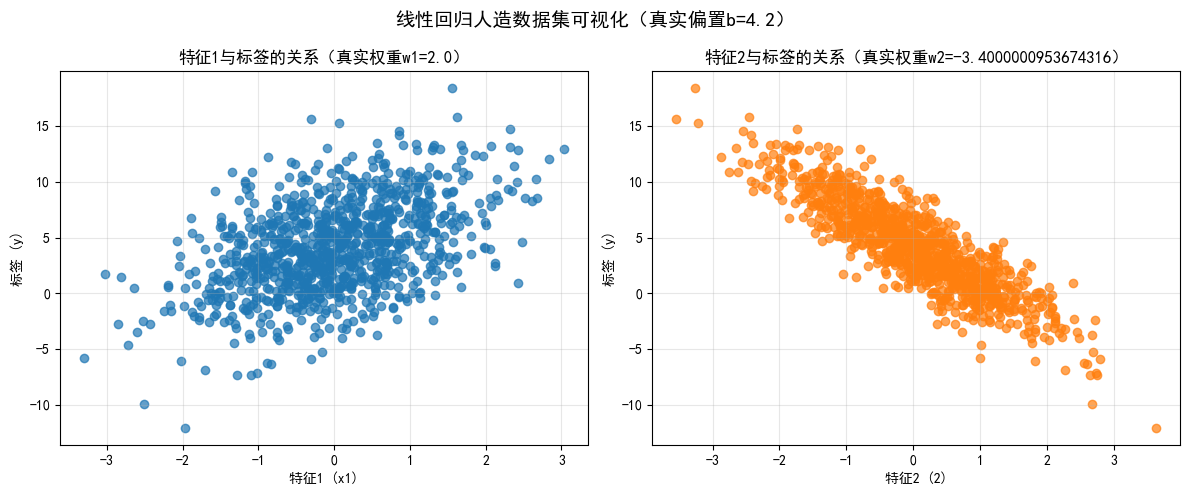

In [9]:
import random
import torch

def synthetic(w, b, num_eg):
    """生成y=Xw+b+噪声：模拟线性回归的人造数据集"""
    # 1. 生成特征X
    X = torch.normal(0, 1, (num_eg, len(w)))  # 特征：num_eg个样本，每个样本有len(w)个特征
    # 2. 计算真实标签（无噪声）
    y = torch.matmul(X, w) + b                # 严格的线性关系：y = X*w + b
    # 3. 加入微小噪声（模拟真实世界的误差）
    y += torch.normal(0, 0.01, y.shape)       # 噪声：均值0，标准差0.01，和y形状一致
    # 4. 返回特征和标签（标签转成列向量）
    return X, y.reshape((-1, 1))              # y的形状从(num_eg,)变成(num_eg, 1)

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic(true_w, true_b, 1000)
# print(f"features: {features}")  # features中的每一行都包含一个二维数据样本
# print(f"labels: {labels}")      # labels中的每一行都包含一维标签值（一个标量）
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "SimHei"
plt.rcParams["axes.unicode_minus"] = False
# 创建2个子图，分别展示特征1、特征2与标签的关系
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# 子图1：特征1（X[:,0]） vs 标签y
ax1.scatter(features[:, 0].numpy(), labels.numpy(), alpha=0.7, color="#1f77b4")
ax1.set_xlabel("特征1 (x1)")
ax1.set_ylabel("标签 (y)")
ax1.set_title(f"特征1与标签的关系（真实权重w1={true_w[0]}）")
ax1.grid(True, alpha=0.3)
# 子图2：特征2（X[:,1]） vs 标签y
ax2.scatter(features[:, 1].numpy(), labels.numpy(), alpha=0.7, color="#ff7f0e")
ax2.set_xlabel("特征2 (2)")
ax2.set_ylabel("标签 (y)")
ax2.set_title(f"特征2与标签的关系（真实权重w2={true_w[1]}）")
ax2.grid(True, alpha=0.3)
fig.suptitle(f"线性回归人造数据集可视化（真实偏置b={true_b}）", fontsize=14)
plt.tight_layout()
plt.show()



### 2.2 读取数据集

In [12]:
def data_iter(batch_size, features, labels):
    # 步骤1：获取总样本数
    num_examples = len(features)  # 比如100个样本，num_examples=100
    # 步骤2：生成样本索引列表（0到num_examples-1）
    indices = list(range(num_examples))  # 比如[0,1,2,...,99]
    # 步骤3：随机打乱索引（核心！保证每批数据是随机的）
    random.shuffle(indices)  # 打乱后可能变成[56, 8, 91, ..., 7]
    
    # 步骤4：按批次遍历打乱后的索引
    # range(0, num_examples, batch_size)：从0开始，每次跳batch_size步
    # 比如batch_size=32，遍历0→32→64→96
    for i in range(0, num_examples, batch_size):
        # 步骤5：取当前批次的索引（处理最后一批不足batch_size的情况）
        # min(i+batch_size, num_examples)：避免索引越界
        # 比如最后一批i=96，i+32=128>100，所以取到100
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        
        # 步骤6：yield返回当前批次的特征和标签（函数暂停，下次继续）
        yield features[batch_indices], labels[batch_indices]
        # 这里还有一个迭代器生成器的知识，很简单略过了
batch_size = 10

### 2.3 初始化模型参数&定义模型

In [11]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True) # 从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重
b = torch.zeros(1, requires_grad=True) # 初始化偏置为0

def linreg(X, w, b):
    return torch.matmul(X, w) + b

### 2.4 定义损失函数

In [10]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
# 除以2是因为求导后平方的2拿到前面去了，要抵消，或者说没必要，不除也行
# y_hat（预测值）由linreg(X, w, b)生成，形状是[batch_size, 1]
# y（真实值）来自数据集labels，是[batch_size,]，需要reshape成[batch_size, 1]才能相减

### 2.5 定义优化器
梯度下降

In [16]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 2.6 训练
我们将执行以下循环：
- 初始化参数
- 重复以下训练，直到完成
  - 计算梯度
  - 更新参数

In [17]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
          l = loss(net(X, w, b), y)
          l.sum().backward()
          sgd([w, b], lr, batch_size)
    with torch.no_grad():
          train_l = loss(net(features, w, b), labels)
          print(f"epoch {epoch + 1}, loss {float(train_l.mean()):f}")


epoch 1, loss 0.033502
epoch 2, loss 0.000132
epoch 3, loss 0.000054


## 3. 从零简单实现
Pytorch的高级封装才是我们以后会经常用到的！
### 3.1 读取数据集

In [23]:
from torch.utils import data  # 数据加载器

def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    # 等价于 data.TensorDataset(features, labels)
    # \*在这里的作用是解包可迭代对象（比如元组、列表）
    # 具体而言是把(features, labels)这个元组 “拆开来”，传给TensorDataset作为两个独立参数
    # TensorDataset作为样本打包器，把多个张量（比如特征 X、标签 y）按 “行” 打包成一个数据集
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
    # DataLoader自动完成 “打乱索引→按批次取样本→返回批次数据” 的全流程



### 3.2 定义模型
这一单层被称为全连接层（fully-connected layer）， 因为它的每一个输入都通过矩阵-向量乘法得到它的每个输出。

In [20]:
from torch import nn # nn 即 neural network
net = nn.Sequential(nn.Linear(2, 1))
# 这里的nn.Linear(2, 1) 就是一个全连接层，它的输入维度是2，输出维度是1
# 即它的权重矩阵是一个2x1的矩阵，偏置向量是一个1维向量

# nn.Sequential 是一个容器，它可以按顺序把多个层（layer）“串起来”
# 这里我们只有一个全连接层，所以就是一个简单的线性模型

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

# net[0]：取出Sequential中的第一层（也是唯一一层）
# .weight.data：访问该层的权重参数的数据部分
# .normal_(0, 0.01)：用正态分布随机数填充（原地操作，_表示原地修改）
# .bias.data.fill_(0)：用0填充偏置

tensor([0.])

### 3.3 损失函数与优化器
优化器的作用：
- 记住模型的所有参数
- 根据梯度自动更新参数
- 提供不同的优化算法变体（SGD只是其中一种）

In [21]:
loss = nn.MSELoss()

trainer = torch.optim.SGD(net.parameters(), lr=0.03)
# net.parameters()：获取模型中所有需要训练的参数（这里就是w和b）
# lr=0.03：学习率（每次更新的步长）
# SGD：随机梯度下降优化器

### 3.4 训练

In [25]:
batch_size = 10
data_loader = load_array((features, labels), batch_size)

num_epochs = 3

for epoch in range(num_epochs):
    for X, y in data_loader:  # 每次取一个小批量（10套房）
        l = loss(net(X), y)
        trainer.zero_grad()   # 梯度清零（不然梯度会累积）
        l.backward()          # 反向传播：计算梯度
        trainer.step()        # 更新参数：w = w - lr * gradient

    # 每个epoch结束后，用全部数据计算一次损失
    l = loss(net(features), labels)
    print(f"epoch {epoch+1}, loss {l.item():f}")

epoch 1, loss 0.000240
epoch 2, loss 0.000107
epoch 3, loss 0.000108


## 4. 分类
| 问题类型 | 预测什么 | 例子                            | 输出形式               |
|----------|------------|---------------------------------|------------------------|
| 回归     | 一个数值   | 房价、温度、销量                   | 单个实数               |
| 分类     | 一个类别   | 猫/狗/鸡、垃圾邮件/非垃圾邮件      | 类别标签（或概率）     |

假设我们要区分猫、鸡、狗三类。我们有几种编码方式：
- 整数编码
- 独热编码（One-Hot Encoding）
  - 每个类别相互独立，没有大小顺序关系

回忆线性回归：输出 = w₁x₁ + w₂x₂ + w₃x₃ + w₄x₄ + b（1个输出）

从线性回归到多类别分类，对于3个类别，我们需要3个独立的线性方程：
```
o₁ = w₁₁x₁ + w₁₂x₂ + w₁₃x₃ + w₁₄x₄ + b₁  # 猫的"得分"
o₂ = w₂₁x₁ + w₂₂x₂ + w₂₃x₃ + w₂₄x₄ + b₂  # 鸡的"得分"
o₃ = w₃₁x₁ + w₃₂x₂ + w₃₃x₃ + w₃₄x₄ + b₃  # 狗的"得分"

- 输入 x: [x₁, x₂, x₃, x₄]  (1×4)
- 权重 W: [ [w₁₁, w₁₂, w₁₃, w₁₄],   # 猫的权重
          [w₂₁, w₂₂, w₂₃, w₂₄],   # 鸡的权重
          [w₃₁, w₃₂, w₃₃, w₃₄] ]  # 狗的权重 (3×4)
- 偏置 b: [b₁, b₂, b₃]  # 每个类别一个偏置
- 输出 o = xWᵀ + b  # 得到3个"得分"
```

![](/img/pytorch/softmax.png)

原始输出`o = [o₁, o₂, o₃]`不能直接当概率，有可能为负且总和不为1。

解决的方法就是 $y = \text{softmax}(o) = \frac{1}{\sum_{i=1}^3 e^{o_i}} \times e^{o_i}$

softmax运算不会改变未规范化的预测之间的大小次序，只会确定分配给每个类别的概率。 因此，在预测过程中，我们仍然可以用下式来选择最有可能的类别
$$
\hat{y} = \arg\max_{i=1}^3 o_i = \arg\max_{i=1}^3 y_i
$$
